<a href="https://colab.research.google.com/github/Firewall-shubham/Shell_Internship/blob/main/shellproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TrashType_Image_Dataset.zip to TrashType_Image_Dataset.zip


In [ ]:
import zipfile

with zipfile.ZipFile("TrashType_Image_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("TrashType_Image_Dataset")

In [17]:
dataset_dir = "/content/TrashType_Image_Dataset/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 123

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [20]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


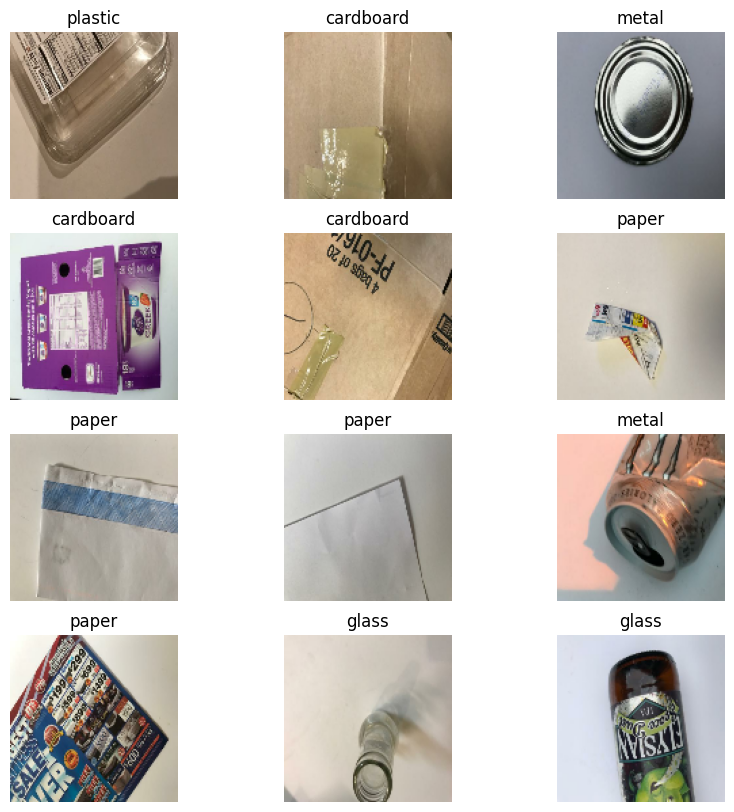

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [23]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [24]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [25]:
class_names = train_ds.class_names
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)
print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 15.83, 'glass': 19.68, 'metal': 16.42, 'paper': 23.24, 'plastic': 19.49, 'trash': 5.34}
{'cardboard': 16.44, 'glass': 20.4, 'metal': 15.45, 'paper': 24.55, 'plastic': 17.43, 'trash': 5.74}
{'cardboard': 18.36, 'glass': 21.48, 'metal': 16.02, 'paper': 24.61, 'plastic': 13.28, 'trash': 6.25}
{'cardboard': 16.14, 'glass': 20.04, 'metal': 15.94, 'paper': 23.89, 'plastic': 18.46, 'trash': 5.54}


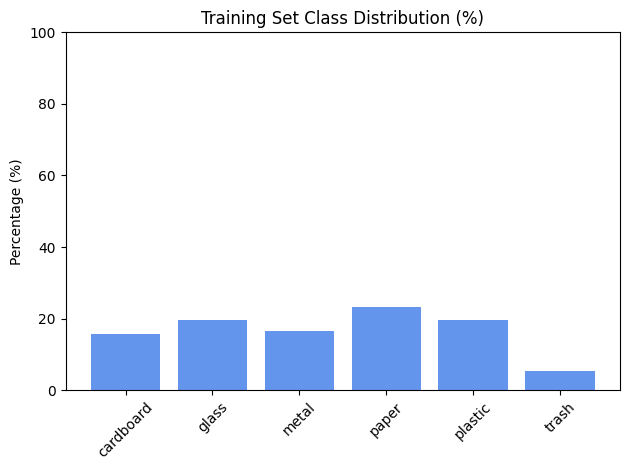

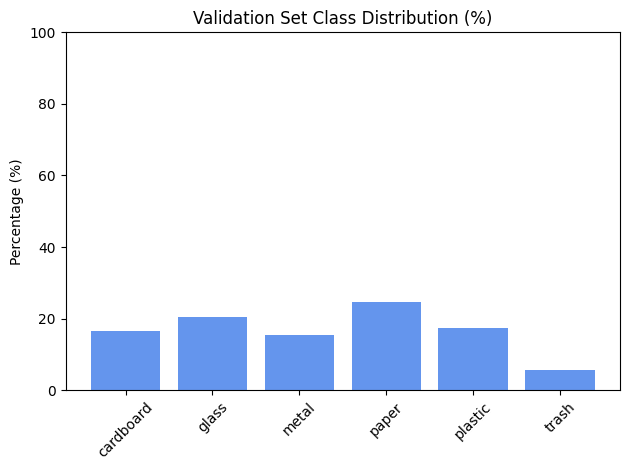

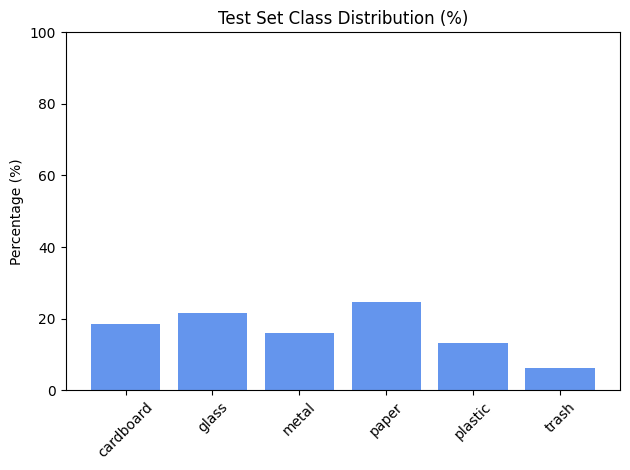

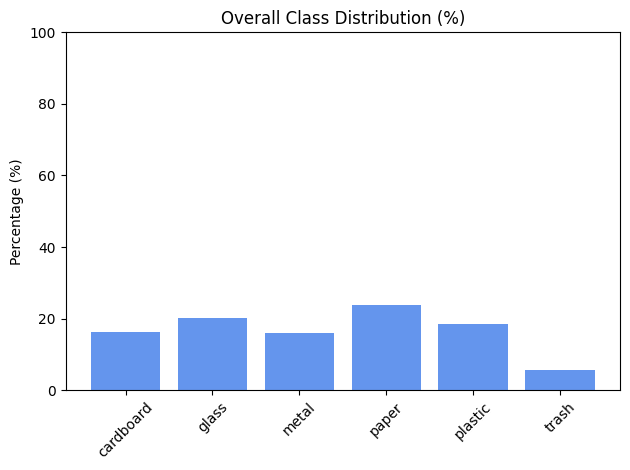

In [26]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [27]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [28]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 320, 1: 398, 2: 332, 3: 470, 4: 394, 5: 108}
Class Weights: {0: np.float64(1.053125), 1: np.float64(0.8467336683417085), 2: np.float64(1.0150602409638554), 3: np.float64(0.7170212765957447), 4: np.float64(0.8553299492385786), 5: np.float64(3.1203703703703702)}


In [29]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [30]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

In [33]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [38]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.2896 - loss: 1.6886 - val_accuracy: 0.6792 - val_loss: 1.1192
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.6461 - loss: 1.0685 - val_accuracy: 0.8079 - val_loss: 0.7490
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.7885 - loss: 0.7044 - val_accuracy: 0.8416 - val_loss: 0.5497
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.8225 - loss: 0.5492 - val_accuracy: 0.8495 - val_loss: 0.4508
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.8685 - loss: 0.3989 - val_accuracy: 0.8634 - val_loss: 0.3894
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9071 - loss: 0.2838 - val_accuracy: 0.8792 - val_loss: 0.3465
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9274 - loss: 0.2349 - val_accuracy: 0.8713 - val_loss: 0.3464
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9403 - loss: 0.1897 - val_accuracy: 0.8891 - v